In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GroupKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, classification_report, recall_score, f1_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
import geopandas as gpd
import time

In [72]:
# ================ 1. Load and Prepare Data ================
# Load your data
df = pd.read_csv('C:\Tugas\Sem 8\TA\Data\Merged_Training_Data_Ver7.csv')

# Check if 'Field' and 'Field_2' columns exist and need to be combined
if 'Field' in df.columns and 'Field_2' in df.columns:
    print("Combining 'Field' and 'Field_2' columns into 'Area'...")
    
    # Create a new 'Area' column to combine the area values
    df['Area'] = df['Field'].copy()
    
    # Fill in values from Field_2 where Field is null but Field_2 is not null
    mask = df['Area'].isna() & df['Field_2'].notna()
    df.loc[mask, 'Area'] = df.loc[mask, 'Field_2']
    
    # Show results of combination
    print("Field nulls:", df['Field'].isna().sum())
    print("Field_2 nulls:", df['Field_2'].isna().sum())
    print("Area nulls:", df['Area'].isna().sum())
    
    # Count distribution of non-null area values
    non_null_areas = df['Area'].dropna()
    if len(non_null_areas) > 0:
        area_counts = non_null_areas.value_counts().sort_index()
        print("\nArea distribution (non-null values only):")
        print(area_counts)
    else:
        print("\nNo non-null values in Area column")
else:
    print("Note: 'Field' and/or 'Field_2' columns not found. Skipping area combination.")

#drop Field and Field_2
df = df.drop(columns=['Field', 'Field_2'])

# Check null values in each column
print("\nNull values per column before cleaning:")
print(df.isnull().sum())

# Identify columns to check for null values (all except 'Label' and 'Area')
columns_to_check = [col for col in df.columns if col not in ['Label', 'Area']]
print(f"\nColumns being checked for null values: {columns_to_check}")

# Drop rows with null values in any column except 'Label' and 'Area'
df = df.dropna(subset=columns_to_check)

print("\nNull values per column after cleaning:")
print(df.isnull().sum())

# Separate label from non labels
known_mask = df['Label'].notna()

# Separate training and prediction data
training_data = df[known_mask].copy()
prediction_data = df[~known_mask].copy()

print(f"\nTraining data shape: {training_data.shape}")
print(f"Prediction data shape: {prediction_data.shape}")

# Define parameters for prediction
feature_cols = ['LST_Celciu','LapseRate', 'NDWI','VHI', 'NDVI', 'Linedense', 'Z', 'xcoord', 'ycoord', 'VCI', 'SMI']

# Check if there are any remaining null values in the feature columns
print("\nNull values in training data features:")
print(training_data[feature_cols].isnull().sum())

# If there are still null values in any feature columns, we can drop those rows
# (This should be redundant now, but keeping as a safety check)
training_data = training_data.dropna(subset=feature_cols)
prediction_data = prediction_data.dropna(subset=feature_cols)

print(f"\nTraining data shape after removing null values in features: {training_data.shape}")
print(f"Prediction data shape after removing null values in features: {prediction_data.shape}")

<>:3: SyntaxWarning: invalid escape sequence '\T'
<>:3: SyntaxWarning: invalid escape sequence '\T'
C:\Users\rakhm\AppData\Local\Temp\ipykernel_20876\411418852.py:3: SyntaxWarning: invalid escape sequence '\T'
  df = pd.read_csv('C:\Tugas\Sem 8\TA\Data\Merged_Training_Data_Ver7.csv')


Combining 'Field' and 'Field_2' columns into 'Area'...
Field nulls: 2450679
Field_2 nulls: 2450681
Area nulls: 2450595

Area distribution (non-null values only):
Area
1.0       5
2.0       1
3.0       1
4.0       1
10.0     46
11.0      2
12.0      4
14.0      1
15.0     18
21.0      1
23.0      1
24.0      1
33.0      1
36.0      1
40.0      1
50.0      1
100.0     2
200.0    23
300.0    59
Name: count, dtype: int64

Null values per column before cleaning:
LapseRate           0
xcoord              0
ycoord              0
LST_Celciu          0
Z              997203
Linedense     1008747
NDVI          1013097
NDWI          1013097
SMI                 0
VCI           1013097
VHI           1013097
Label         2450595
Area          2450595
dtype: int64

Columns being checked for null values: ['LapseRate', 'xcoord', 'ycoord', 'LST_Celciu', 'Z', 'Linedense', 'NDVI', 'NDWI', 'SMI', 'VCI', 'VHI']

Null values per column after cleaning:
LapseRate           0
xcoord              0
ycoord      

In [73]:
# Creating feature matrix, target vector, splitting data
# Create feature matrix (X) and target vector (y)
X_train_full = training_data[feature_cols].values
y_train_full = training_data['Label'].values

# Feature matrix for prediction points
X_predict = prediction_data[feature_cols].values
print(len(X_predict))
# Check distribution of labels
unique_labels, counts = np.unique(y_train_full, return_counts=True)
print("\nLabel distribution:")
for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count} ({count/len(y_train_full)*100:.2f}%)")

# Split the labeled data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_train_full, 
    y_train_full, 
    test_size=0.3,  # 65% training, 35% testing
    random_state=60,  
    stratify=y_train_full  # Maintain the same proportion of labels in train and test
)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

1428018

Label distribution:
Label 0.0: 84 (49.41%)
Label 1.0: 86 (50.59%)

Training set shape: (119, 11)
Testing set shape: (51, 11)


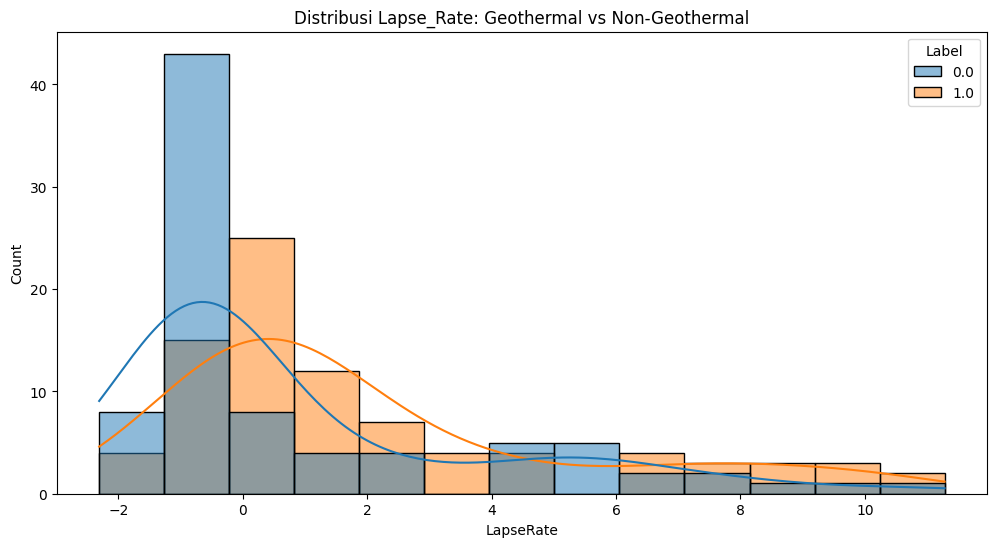

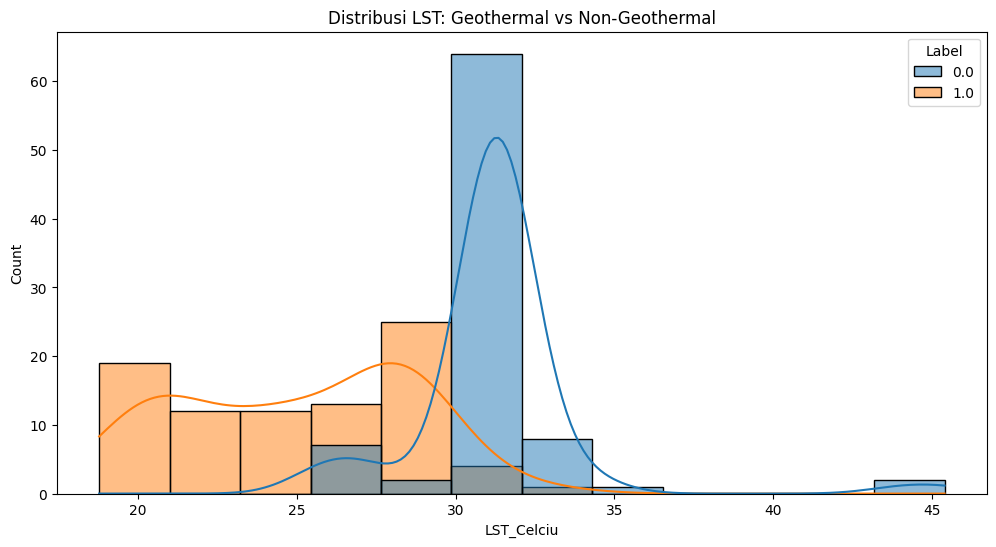

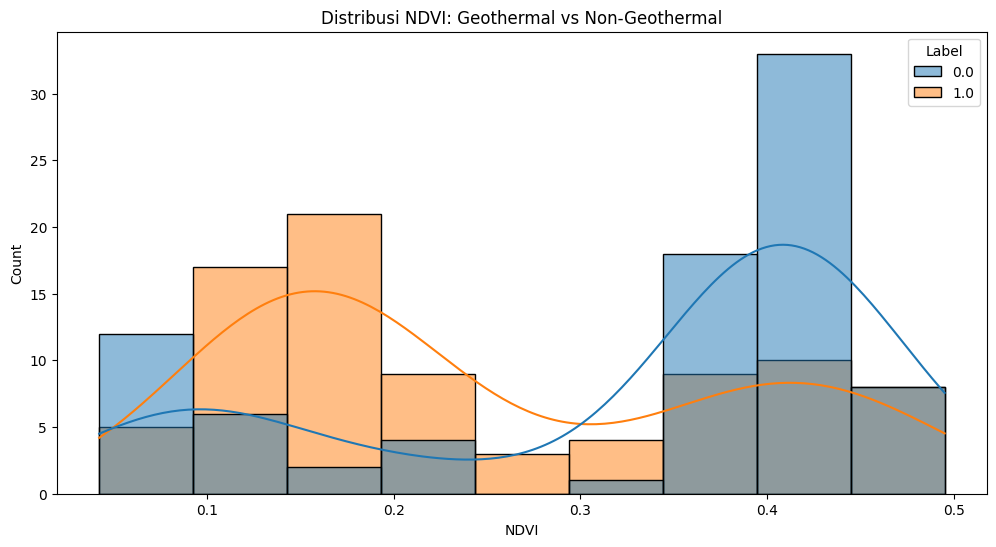

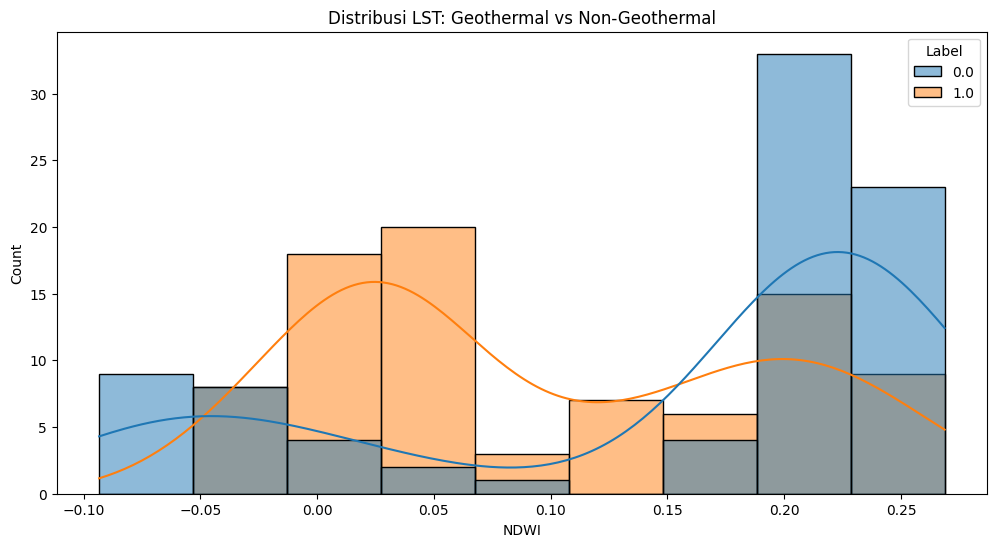

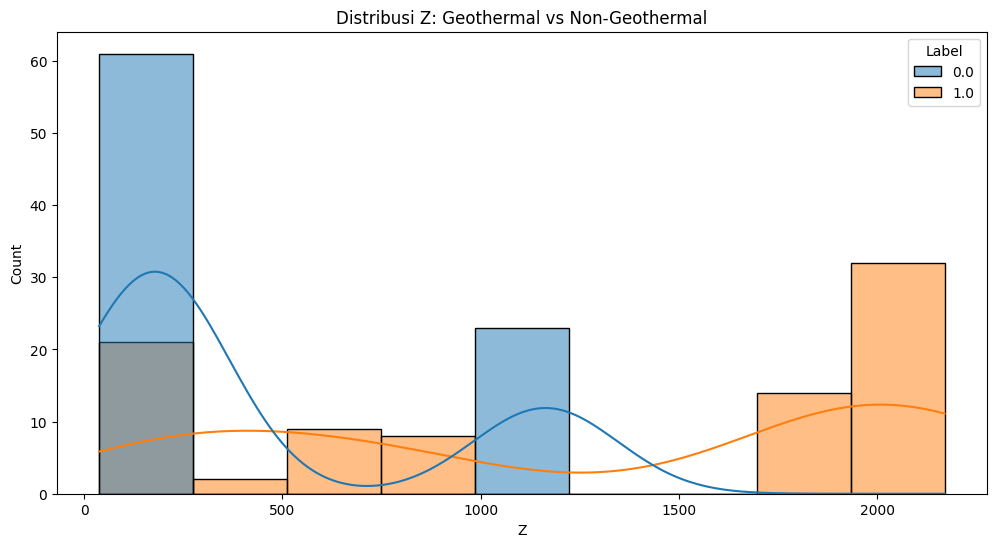

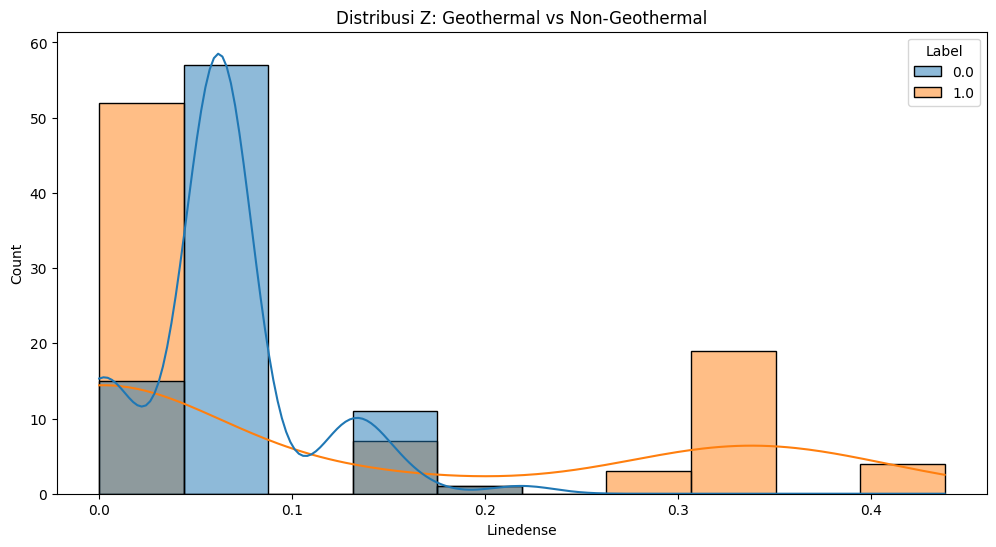

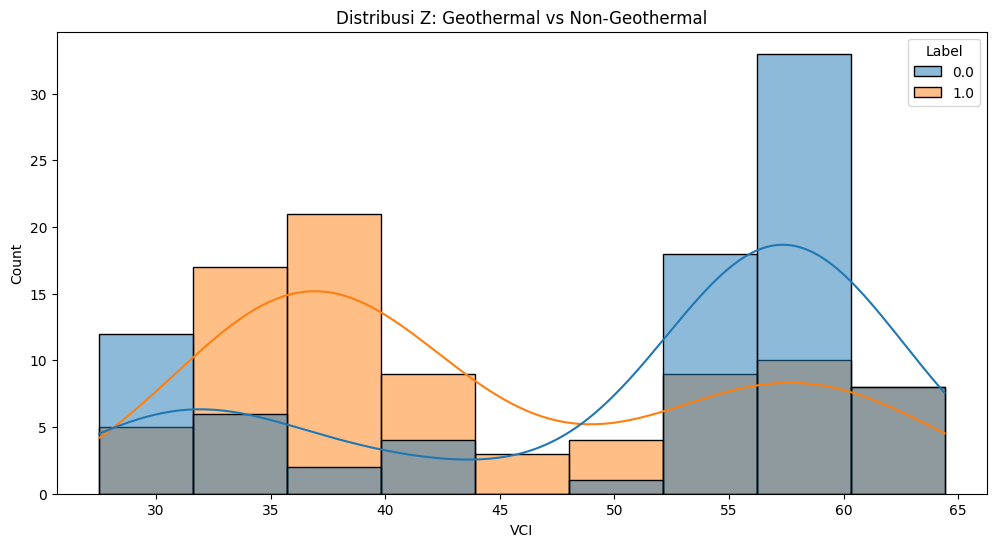

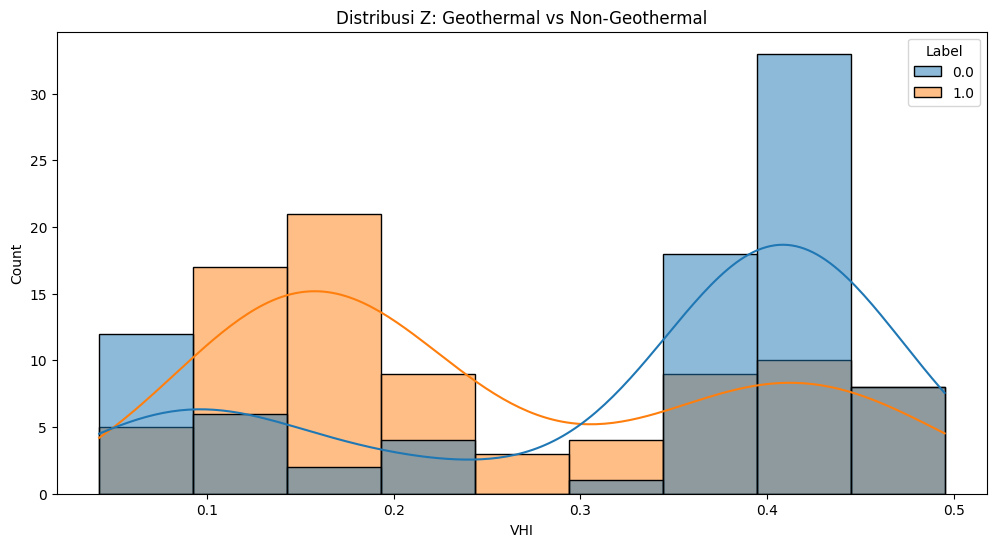

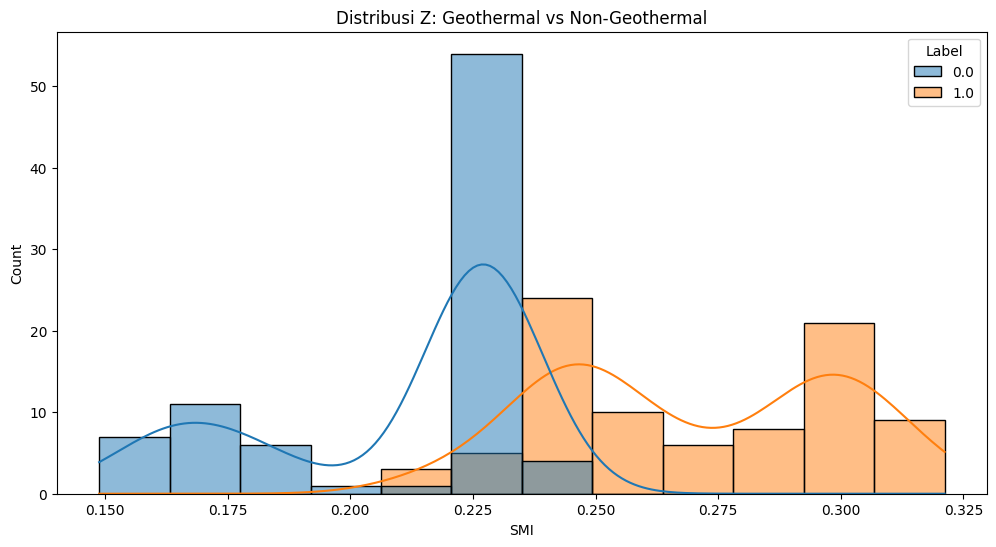

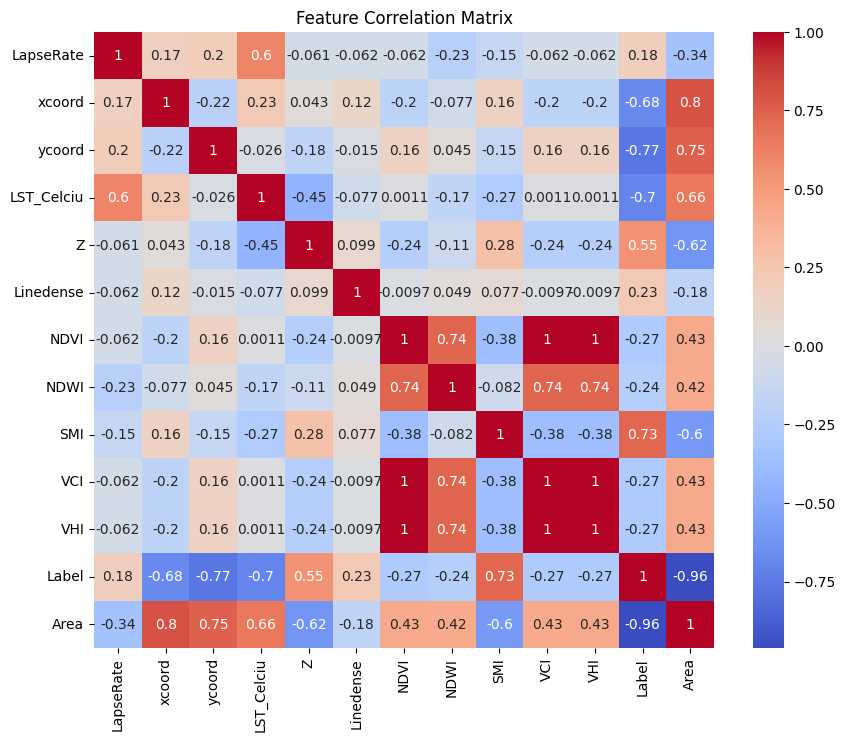

In [59]:
#plots
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='LapseRate', hue='Label', kde=True)
plt.title("Distribusi Lapse_Rate: Geothermal vs Non-Geothermal")
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='LST_Celciu', hue='Label', kde=True)
plt.title("Distribusi LST: Geothermal vs Non-Geothermal")
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='NDVI', hue='Label', kde=True)
plt.title("Distribusi NDVI: Geothermal vs Non-Geothermal")
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='NDWI', hue='Label', kde=True)
plt.title("Distribusi LST: Geothermal vs Non-Geothermal")
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Z', hue='Label', kde=True)
plt.title("Distribusi Z: Geothermal vs Non-Geothermal")
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Linedense', hue='Label', kde=True)
plt.title("Distribusi Z: Geothermal vs Non-Geothermal")
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='VCI', hue='Label', kde=True)
plt.title("Distribusi Z: Geothermal vs Non-Geothermal")
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='VHI', hue='Label', kde=True)
plt.title("Distribusi Z: Geothermal vs Non-Geothermal")
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='SMI', hue='Label', kde=True)
plt.title("Distribusi Z: Geothermal vs Non-Geothermal")
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

In [74]:
def run_area_selection_trials(training_data, feature_cols, n_trials=10, random_seed=42):
    """
    Run multiple trials with different area splits to find the best performing model.
    Now includes detailed sample size tracking.
    
    Parameters:
    -----------
    training_data : DataFrame
        DataFrame containing features, labels, and Area column
    feature_cols : list
        List of feature column names to use
    n_trials : int
        Number of trials to run
    random_seed : int
        Random seed for reproducibility
    
    Returns:
    --------
    DataFrame with results from all trials
    """
    print(f"\n=== Running {n_trials} Area Selection Trials ===")
    np.random.seed(random_seed)
    
    # List to store results
    trial_results = []
    
    # Get all unique areas for reporting
    if 'Area' in training_data.columns:
        unique_areas = training_data['Area'].dropna().unique()
        print(f"Found {len(unique_areas)} unique areas: {sorted(unique_areas)}")
    
    for trial in range(n_trials):
        print(f"\nTrial {trial+1}/{n_trials}")
        # Use different random seed for each trial
        current_seed = random_seed + trial
        
        # Split data
        X_train, X_test, y_train, y_test, train_areas, test_areas = split_by_areas(
            training_data, 
            feature_cols,
            test_size=0.3,
            random_state=current_seed
        )
        
        # Skip if we couldn't do area-based splitting
        if train_areas is None or test_areas is None:
            print("Skipping trial due to missing Area information")
            continue
            
        # Record sample sizes (in pixels)
        train_pixels = X_train.shape[0]
        test_pixels = X_test.shape[0]
        
        # Calculate class distribution in training and testing sets
        train_class_counts = np.unique(y_train, return_counts=True)
        test_class_counts = np.unique(y_test, return_counts=True)
        
        # Format class counts for display
        train_class_dist = dict(zip(train_class_counts[0], train_class_counts[1]))
        test_class_dist = dict(zip(test_class_counts[0], test_class_counts[1]))
        
        print(f"Training set: {train_pixels} pixels ({len(train_areas)} areas)")
        print(f"Training class distribution: {train_class_dist}")
        print(f"Testing set: {test_pixels} pixels ({len(test_areas)} areas)")
        print(f"Testing class distribution: {test_class_dist}")
            
        # Train a basic XGBoost model
        model = xgb.XGBClassifier(
            objective='binary:logistic',
            random_state=current_seed,
            n_estimators=100,
            learning_rate=0.1
        )
        
        # Calculate class weights
        positive_samples = np.sum(y_train == 1)
        negative_samples = np.sum(y_train == 0)
        if positive_samples > 0:
            scale_pos_weight = negative_samples / positive_samples
            model.scale_pos_weight = scale_pos_weight
            print(f"Class balance - Negative:Positive ratio = {scale_pos_weight:.2f}")
        
        # Fit model
        model.fit(X_train, y_train)
        
        # Evaluate
        metrics = evaluate_model(model, X_train, X_test, y_train, y_test)
        
        # Calculate pixels per area for reporting
        train_pixels_per_area = train_pixels / len(train_areas) if len(train_areas) > 0 else 0
        test_pixels_per_area = test_pixels / len(test_areas) if len(test_areas) > 0 else 0
        
        # Store results
        trial_results.append({
            'trial': trial + 1,
            'train_areas': sorted(train_areas),
            'test_areas': sorted(test_areas),
            'num_train_areas': len(train_areas),
            'num_test_areas': len(test_areas),
            'train_pixels': train_pixels,
            'test_pixels': test_pixels,
            'pixels_per_train_area': round(train_pixels_per_area, 1),
            'pixels_per_test_area': round(test_pixels_per_area, 1),
            'train_pos_class': train_class_dist.get(1, 0),
            'train_neg_class': train_class_dist.get(0, 0),
            'test_pos_class': test_class_dist.get(1, 0),
            'test_neg_class': test_class_dist.get(0, 0),
            'train_accuracy': metrics['train_accuracy'],
            'test_accuracy': metrics['test_accuracy'],
            'test_auc': metrics['test_auc'],
            'test_f1': metrics['test_f1']
        })
        
        print(f"Training accuracy: {metrics['train_accuracy']:.4f}")
        print(f"Testing accuracy: {metrics['test_accuracy']:.4f}")
        if metrics['test_auc'] is not None:
            print(f"Testing AUC: {metrics['test_auc']:.4f}")
        print(f"Testing F1: {metrics['test_f1']:.4f}")
    
    # Convert to DataFrame for easier analysis
    results_df = pd.DataFrame(trial_results)
    
    # Find best trial based on test metrics
    best_auc_idx = results_df['test_auc'].idxmax() if 'test_auc' in results_df.columns else None
    best_f1_idx = results_df['test_f1'].idxmax()
    best_acc_idx = results_df['test_accuracy'].idxmax()
    
    print("\n=== Trial Results Summary ===")
    print(results_df[['trial', 'train_pixels', 'test_pixels', 'test_accuracy', 'test_auc', 'test_f1']].to_string(index=False))
    
    # Calculate average performance and sample sizes
    mean_metrics = results_df[['train_pixels', 'test_pixels', 'test_accuracy', 'test_auc', 'test_f1']].mean()
    std_metrics = results_df[['train_pixels', 'test_pixels', 'test_accuracy', 'test_auc', 'test_f1']].std()
    
    print("\n=== Average Performance ===")
    print(f"Training set size: {mean_metrics['train_pixels']:.1f} ± {std_metrics['train_pixels']:.1f} pixels")
    print(f"Testing set size: {mean_metrics['test_pixels']:.1f} ± {std_metrics['test_pixels']:.1f} pixels")
    print(f"Test accuracy: {mean_metrics['test_accuracy']:.4f} ± {std_metrics['test_accuracy']:.4f}")
    if 'test_auc' in mean_metrics:
        print(f"Test AUC: {mean_metrics['test_auc']:.4f} ± {std_metrics['test_auc']:.4f}")
    print(f"Test F1: {mean_metrics['test_f1']:.4f} ± {std_metrics['test_f1']:.4f}")
    
    # Print best trial information
    print("\n=== Best Trial by Test Accuracy ===")
    best_acc_trial = results_df.iloc[best_acc_idx]
    print(f"Trial {best_acc_trial['trial']}")
    print(f"Test Accuracy: {best_acc_trial['test_accuracy']:.4f}")
    print(f"Training: {best_acc_trial['train_pixels']} pixels from {best_acc_trial['num_train_areas']} areas")
    print(f"Testing: {best_acc_trial['test_pixels']} pixels from {best_acc_trial['num_test_areas']} areas")
    print(f"Training Areas: {best_acc_trial['train_areas']}")
    print(f"Testing Areas: {best_acc_trial['test_areas']}")
    
    if best_auc_idx is not None:
        print("\n=== Best Trial by Test AUC ===")
        best_auc_trial = results_df.iloc[best_auc_idx]
        print(f"Trial {best_auc_trial['trial']}")
        print(f"Test AUC: {best_auc_trial['test_auc']:.4f}")
        print(f"Training: {best_auc_trial['train_pixels']} pixels from {best_auc_trial['num_train_areas']} areas")
        print(f"Testing: {best_auc_trial['test_pixels']} pixels from {best_auc_trial['num_test_areas']} areas")
        print(f"Training Areas: {best_auc_trial['train_areas']}")
        print(f"Testing Areas: {best_auc_trial['test_areas']}")
    
    print("\n=== Best Trial by Test F1 Score ===")
    best_f1_trial = results_df.iloc[best_f1_idx]
    print(f"Trial {best_f1_trial['trial']}")
    print(f"Test F1: {best_f1_trial['test_f1']:.4f}")
    print(f"Training: {best_f1_trial['train_pixels']} pixels from {best_f1_trial['num_train_areas']} areas")
    print(f"Testing: {best_f1_trial['test_pixels']} pixels from {best_f1_trial['num_test_areas']} areas")
    print(f"Training Areas: {best_f1_trial['train_areas']}")
    print(f"Testing Areas: {best_f1_trial['test_areas']}")
    
    # Add pixel distribution chart
    plt.figure(figsize=(10, 6))
    x = np.arange(len(results_df))
    width = 0.35
    
    plt.bar(x - width/2, results_df['train_pixels'], width, label='Training Pixels')
    plt.bar(x + width/2, results_df['test_pixels'], width, label='Testing Pixels')
    
    plt.xlabel('Trial')
    plt.ylabel('Number of Pixels')
    plt.title('Pixel Distribution Across Trials')
    plt.xticks(x, results_df['trial'])
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return results_df

In [75]:
def tune_hyperparameters(training_data, feature_cols, train_areas, test_areas, param_grid=None):
    """
    Perform hyperparameter tuning using GridSearchCV while respecting area-based splitting.
    
    Parameters:
    -----------
    training_data : DataFrame
        DataFrame containing features, labels, and Area column
    feature_cols : list
        List of feature column names
    train_areas : list
        List of area IDs to use for training
    test_areas : list
        List of area IDs to use for testing
    param_grid : dict or None
        Parameter grid for XGBoost. If None, a default grid will be used.
    
    Returns:
    --------
    best_model, best_params, cv_results
    """
    print("\n=== Hyperparameter Tuning with GridSearchCV ===")
    
    # Create masks for train/test splitting
    train_mask = training_data['Area'].isin(train_areas)
    test_mask = training_data['Area'].isin(test_areas)
    
    # Handle null areas (assign to training)
    null_mask = training_data['Area'].isna()
    if null_mask.any():
        print(f"Found {null_mask.sum()} rows with null Area. Adding to training set.")
        train_mask = train_mask | null_mask
    
    # Extract features and labels - using only training data
    # This is critical - we're only using the training subset now
    train_subset = training_data.loc[train_mask].copy()
    X_train = train_subset[feature_cols].values
    y_train = train_subset['Label'].values
    
    # Also extract test data
    X_test = training_data.loc[test_mask, feature_cols].values
    y_test = training_data.loc[test_mask, 'Label'].values
    
    print(f"Training set: {X_train.shape[0]} pixels from {len(train_areas)} areas")
    print(f"Testing set: {X_test.shape[0]} pixels from {len(test_areas)} areas")
    
    # Default parameter grid if not provided
    if param_grid is None:
        # Use a smaller grid for faster tuning
        param_grid = {
            'max_depth': [3, 5, 7],
            'learning_rate': [0.05, 0.1, 0.2],
            'n_estimators': [50, 100, 200],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        }
    
    # Calculate class weight for imbalanced data
    positive_samples = np.sum(y_train == 1)
    negative_samples = np.sum(y_train == 0)
    scale_pos_weight = negative_samples / positive_samples if positive_samples > 0 else 1.0
    print(f"Class balance - Negative:Positive ratio = {scale_pos_weight:.2f}")
    
    # Create base estimator
    base_model = xgb.XGBClassifier(
        objective='binary:logistic',
        random_state=42,
        scale_pos_weight=scale_pos_weight,
        eval_metric='auc'
    )
    
    # Calculate total combinations (for progress reporting)
    total_combinations = np.prod([len(values) for values in param_grid.values()])
    print(f"Searching across {total_combinations} parameter combinations")
    
    # FIXED: Instead of creating a custom splitter, we'll use a simpler approach
    # Define the CV strategy - either use StratifiedKFold on the training subset
    # or create a simple area-based splits
    
    # Option 1: Create a list of train/val splits based on areas
    def create_area_based_splits(train_subset, n_splits=5):
        """Create predefined splits based on areas within training data"""
        # Get unique areas in training subset
        unique_areas = train_subset['Area'].dropna().unique()
        n_areas = len(unique_areas)
        
        # Adjust splits if needed
        if n_areas < n_splits:
            n_splits = max(2, n_areas)  # At least 2 splits if possible
            print(f"Adjusted to {n_splits} CV folds due to limited number of areas")
        
        # Shuffle areas
        np.random.seed(42)
        np.random.shuffle(unique_areas)
        
        # Create folds of areas
        area_folds = np.array_split(unique_areas, n_splits)
        
        # Generate train/val splits
        splits = []
        for i in range(n_splits):
            # Areas for this validation fold
            val_areas = area_folds[i]
            train_areas_cv = np.concatenate([area_folds[j] for j in range(n_splits) if j != i])
            
            # Create indices
            train_indices = train_subset[train_subset['Area'].isin(train_areas_cv)].index
            val_indices = train_subset[train_subset['Area'].isin(val_areas)].index
            
            # Convert to array indices within the training subset
            train_idx_array = np.where(train_subset.index.isin(train_indices))[0]
            val_idx_array = np.where(train_subset.index.isin(val_indices))[0]
            
            splits.append((train_idx_array, val_idx_array))
        
        return splits
    
    # Create CV splits
    cv_splits = create_area_based_splits(train_subset)
    
    # Option 2: If the above still causes issues, fall back to standard StratifiedKFold
    # from sklearn.model_selection import StratifiedKFold
    # cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Setup GridSearchCV
    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=cv_splits,  # Use our predefined splits
        verbose=2,
        n_jobs=-1
    )
    
    # Run hyperparameter search
    print("Starting hyperparameter tuning...")
    start_time = time.time()
    
    try:
        grid_search.fit(X_train, y_train)
        tuning_time = time.time() - start_time
        print(f"Hyperparameter tuning completed in {tuning_time:.2f} seconds")
        
        # Get best parameters and model
        best_params = grid_search.best_params_
        best_model = grid_search.best_estimator_
        best_score = grid_search.best_score_
        
        print("\n=== Best Parameters ===")
        for param, value in best_params.items():
            print(f"{param}: {value}")
        print(f"Cross-validation AUC: {best_score:.4f}")
        
    except Exception as e:
        print(f"Error during hyperparameter tuning: {e}")
        print("Falling back to default parameters")
        
        # Create a model with default parameters
        best_model = xgb.XGBClassifier(
            objective='binary:logistic',
            random_state=42,
            scale_pos_weight=scale_pos_weight,
            max_depth=5,
            learning_rate=0.1,
            n_estimators=100,
            subsample=0.8,
            colsample_bytree=0.8
        )
        best_model.fit(X_train, y_train)
        best_params = best_model.get_params()
        cv_results = None
        
        # Skip evaluation and return early
        return best_model, best_params, None
    
    # Evaluate on the test set
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    
    test_accuracy = accuracy_score(y_test, y_pred)
    test_auc = roc_auc_score(y_test, y_pred_proba)
    test_f1 = f1_score(y_test, y_pred)
    
    print("\n=== Test Set Performance ===")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"AUC: {test_auc:.4f}")
    print(f"F1 Score: {test_f1:.4f}")
    print(f"Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix (Best Model)')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {test_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    xgb.plot_importance(best_model, importance_type='weight')
    plt.title('XGBoost Feature Importance (Best Model)')
    plt.tight_layout()
    plt.show()
    
    return best_model, best_params, grid_search.cv_results_

=== Running Area Selection Trials ===

=== Running 10 Area Selection Trials ===
Found 19 unique areas: [np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(10.0), np.float64(11.0), np.float64(12.0), np.float64(14.0), np.float64(15.0), np.float64(21.0), np.float64(23.0), np.float64(24.0), np.float64(33.0), np.float64(36.0), np.float64(40.0), np.float64(50.0), np.float64(100.0), np.float64(200.0), np.float64(300.0)]

Trial 1/10
Found 19 unique areas: [np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(10.0), np.float64(11.0), np.float64(12.0), np.float64(14.0), np.float64(15.0), np.float64(21.0), np.float64(23.0), np.float64(24.0), np.float64(33.0), np.float64(36.0), np.float64(40.0), np.float64(50.0), np.float64(100.0), np.float64(200.0), np.float64(300.0)]
Training areas (14): [np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(11.0), np.float64(12.0), np.float64(14.0), np.float64(15.0), np.float64(21.0)

c:\Users\rakhm\miniconda3\envs\gee\Lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\rakhm\miniconda3\envs\gee\Lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\rakhm\miniconda3\envs\gee\Lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\rakhm\miniconda3\envs\gee\Lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\rakhm\miniconda3\envs\gee\Lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defi

Training set label distribution: {np.float64(0.0): np.int64(84), np.float64(1.0): np.int64(64)}
Testing set label distribution: {np.float64(1.0): np.int64(22)}
Training set: 148 pixels (14 areas)
Training class distribution: {np.float64(0.0): np.int64(84), np.float64(1.0): np.int64(64)}
Testing set: 22 pixels (5 areas)
Testing class distribution: {np.float64(1.0): np.int64(22)}
Class balance - Negative:Positive ratio = 1.31
Training accuracy: 1.0000
Testing accuracy: 1.0000
Testing AUC: nan
Testing F1: 1.0000

Trial 10/10
Found 19 unique areas: [np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(10.0), np.float64(11.0), np.float64(12.0), np.float64(14.0), np.float64(15.0), np.float64(21.0), np.float64(23.0), np.float64(24.0), np.float64(33.0), np.float64(36.0), np.float64(40.0), np.float64(50.0), np.float64(100.0), np.float64(200.0), np.float64(300.0)]
Training areas (14): [np.float64(1.0), np.float64(2.0), np.float64(10.0), np.float64(11.0), np.float64(12.0

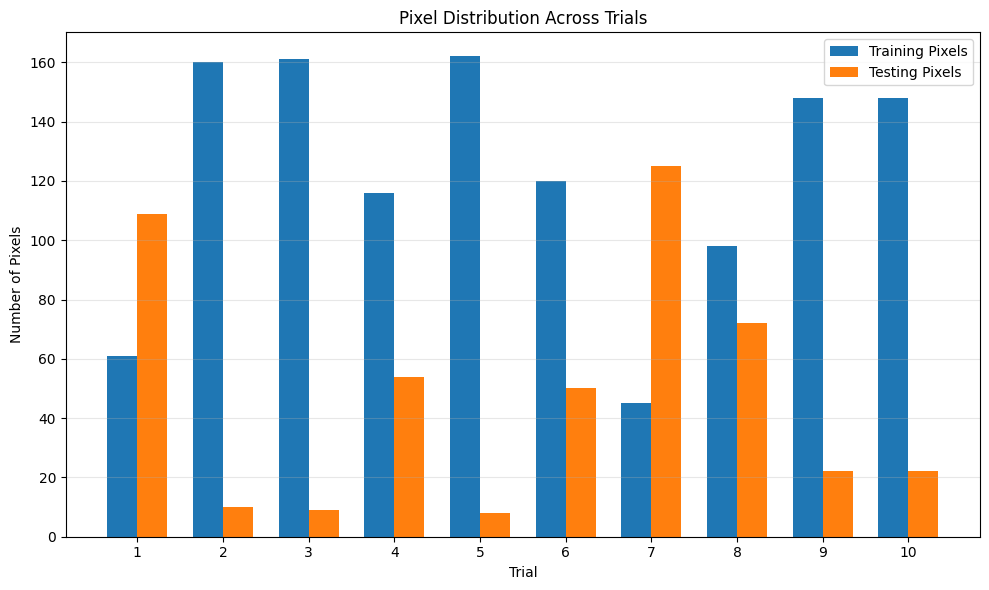


Best trial selected based on test_auc
Best trial index: 3
Best test_auc: 1.0000
Selected training areas: [np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(11.0), np.float64(14.0), np.float64(15.0), np.float64(21.0), np.float64(24.0), np.float64(33.0), np.float64(36.0), np.float64(40.0), np.float64(200.0), np.float64(300.0)]
Selected testing areas: [np.float64(10.0), np.float64(12.0), np.float64(23.0), np.float64(50.0), np.float64(100.0)]

=== Starting Hyperparameter Tuning ===

=== Hyperparameter Tuning with GridSearchCV ===
Training set: 116 pixels from 14 areas
Testing set: 54 pixels from 5 areas
Class balance - Negative:Positive ratio = 2.41
Searching across 108 parameter combinations
Starting hyperparameter tuning...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Hyperparameter tuning completed in 1.47 seconds

=== Best Parameters ===
colsample_bytree: 0.8
learning_rate: 0.05
max_depth: 3
n_estimators: 50
subsample: 0.8
Cross-validatio

c:\Users\rakhm\miniconda3\envs\gee\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


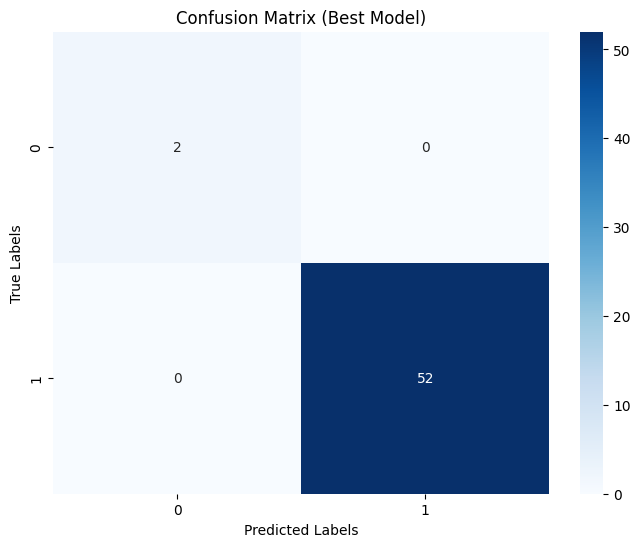

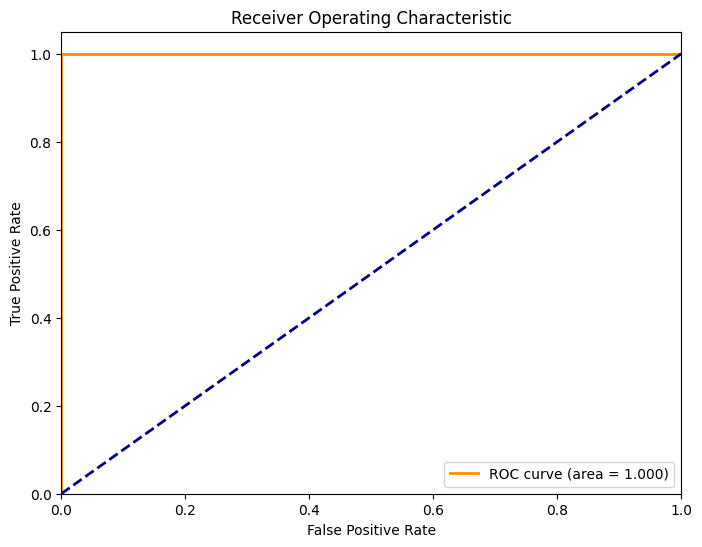

<Figure size 1000x600 with 0 Axes>

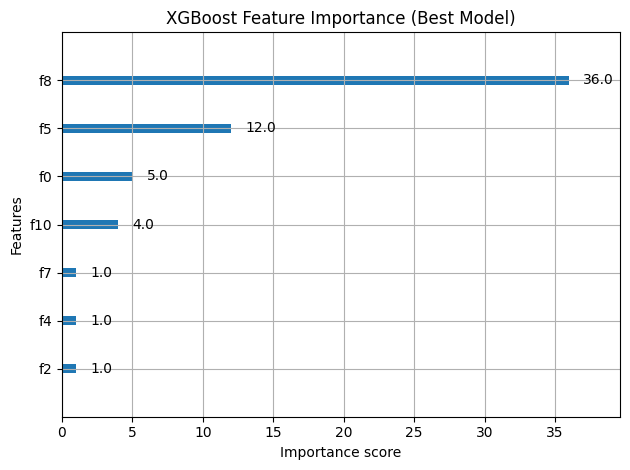


=== Making Final Predictions ===

Final predictions shape: (1428018, 5)
Prediction results preview:
   Probability  Prediction       xcoord        ycoord  Area
0     0.945837           1  339133.7054  9.029270e+06   NaN
1     0.945837           1  339043.7054  9.029270e+06   NaN
2     0.945837           1  338953.7054  9.029270e+06   NaN
3     0.945837           1  338863.7054  9.029270e+06   NaN
4     0.945837           1  338773.7054  9.029270e+06   NaN
Final predictions saved to 'geothermal_predictions_final.csv'

Prediction Summary:
Total points predicted: 1,428,018
Predicted Geothermal: 787,042 (55.11%)
Predicted Non-Geothermal: 640,976 (44.89%)


In [76]:
# First, you need to run the area selection trials to get trial_results
print("=== Running Area Selection Trials ===")

# Run the area selection trials (this will create trial_results)
trial_results = run_area_selection_trials(
    training_data, 
    feature_cols, 
    n_trials=10,  # Adjust number of trials as needed
    random_seed=60
)

# Find the best trial based on your preferred metric
# You can choose from: 'test_accuracy', 'test_auc', 'test_f1'
best_trial_metric = 'test_auc'  # Change this to your preferred metric

if best_trial_metric in trial_results.columns:
    best_trial_idx = trial_results[best_trial_metric].idxmax()
    print(f"\nBest trial selected based on {best_trial_metric}")
    print(f"Best trial index: {best_trial_idx}")
    print(f"Best {best_trial_metric}: {trial_results.loc[best_trial_idx, best_trial_metric]:.4f}")
else:
    # Fallback to test_accuracy if the metric doesn't exist
    best_trial_idx = trial_results['test_accuracy'].idxmax()
    print(f"\nBest trial selected based on test_accuracy (fallback)")
    print(f"Best trial index: {best_trial_idx}")
    print(f"Best test_accuracy: {trial_results.loc[best_trial_idx, 'test_accuracy']:.4f}")

# Extract the best areas from the trial results
best_train_areas = trial_results.loc[best_trial_idx, 'train_areas']
best_test_areas = trial_results.loc[best_trial_idx, 'test_areas']

print(f"Selected training areas: {best_train_areas}")
print(f"Selected testing areas: {best_test_areas}")

# Now perform hyperparameter tuning with the best areas
print("\n=== Starting Hyperparameter Tuning ===")
best_model, best_params, cv_results = tune_hyperparameters(
    training_data,
    feature_cols,
    best_train_areas,
    best_test_areas
)

# Use the best model for predictions
print("\n=== Making Final Predictions ===")
predict_proba = best_model.predict_proba(X_predict)[:, 1]
predict_binary = best_model.predict(X_predict)

# Create results dataframe
results_df = pd.DataFrame({
    'Probability': predict_proba,
    'Prediction': predict_binary
})

# Add coordinates and other columns from prediction_data if available
prediction_cols_to_add = ['xcoord', 'ycoord', 'Area']  # Add other columns as needed
for col in prediction_cols_to_add:
    if col in prediction_data.columns:
        results_df[col] = prediction_data[col].values

print(f"\nFinal predictions shape: {results_df.shape}")
print("Prediction results preview:")
print(results_df.head())

# Save the results
results_df.to_csv('geothermal_predictions_final.csv', index=False)
print("Final predictions saved to 'geothermal_predictions_final.csv'")

# Show prediction summary
geothermal_count = sum(predict_binary == 1)
print(f"\nPrediction Summary:")
print(f"Total points predicted: {len(predict_binary):,}")
print(f"Predicted Geothermal: {geothermal_count:,} ({geothermal_count/len(predict_binary)*100:.2f}%)")
print(f"Predicted Non-Geothermal: {len(predict_binary) - geothermal_count:,} ({(len(predict_binary) - geothermal_count)/len(predict_binary)*100:.2f}%)")


=== Hyperparameter Tuning with GridSearchCV ===
Training set: 116 pixels from 14 areas
Testing set: 54 pixels from 5 areas
Class balance - Negative:Positive ratio = 2.41
Searching across 108 parameter combinations
Starting hyperparameter tuning...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Hyperparameter tuning completed in 1.41 seconds

=== Best Parameters ===
colsample_bytree: 0.8
learning_rate: 0.05
max_depth: 3
n_estimators: 50
subsample: 0.8
Cross-validation AUC: nan

=== Test Set Performance ===
Accuracy: 1.0000
AUC: 1.0000
F1 Score: 1.0000
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         2
         1.0       1.00      1.00      1.00        52

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54



c:\Users\rakhm\miniconda3\envs\gee\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


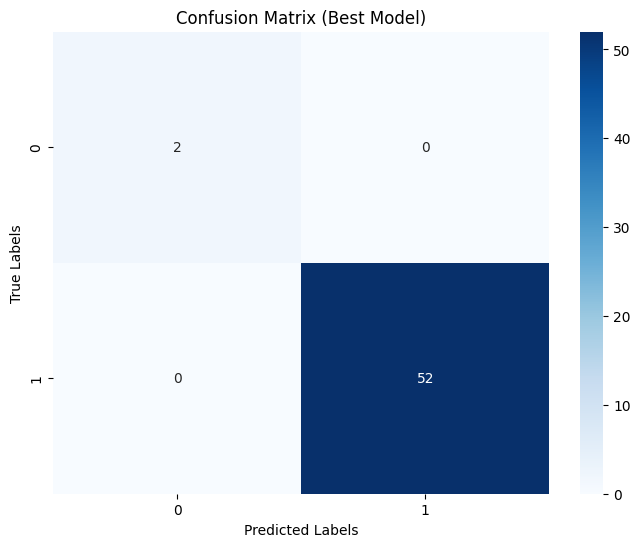

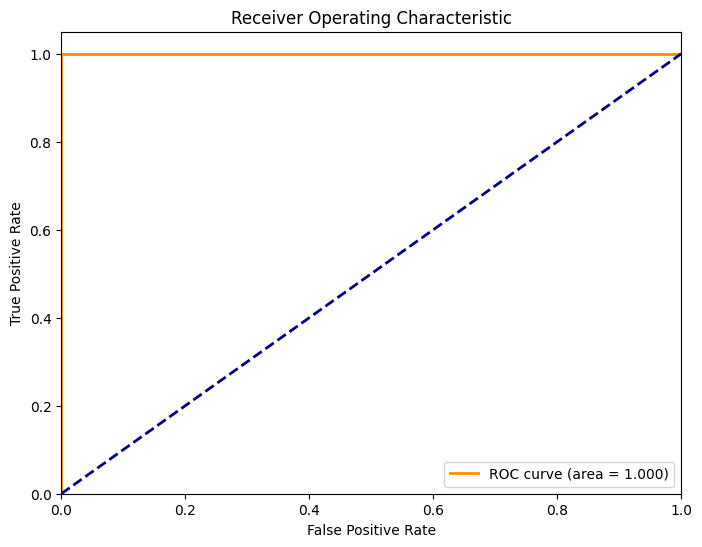

<Figure size 1000x600 with 0 Axes>

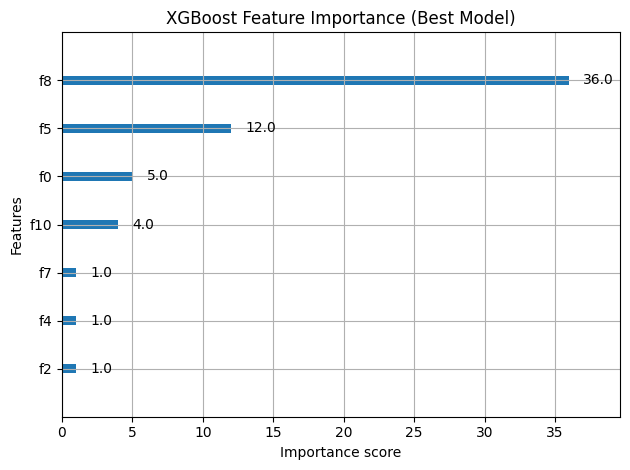

In [77]:
# After finding the best areas from trials
best_train_areas = trial_results.loc[best_trial_idx, 'train_areas']
best_test_areas = trial_results.loc[best_trial_idx, 'test_areas']

# Perform hyperparameter tuning with the fixed function
best_model, best_params, cv_results = tune_hyperparameters(
    training_data, 
    feature_cols, 
    best_train_areas, 
    best_test_areas
)

# Use the best model for predictions
predict_proba = best_model.predict_proba(X_predict)[:, 1]
predict_binary = best_model.predict(X_predict)


C:\Users\rakhm\AppData\Local\Temp\ipykernel_20876\1211689939.py:441: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


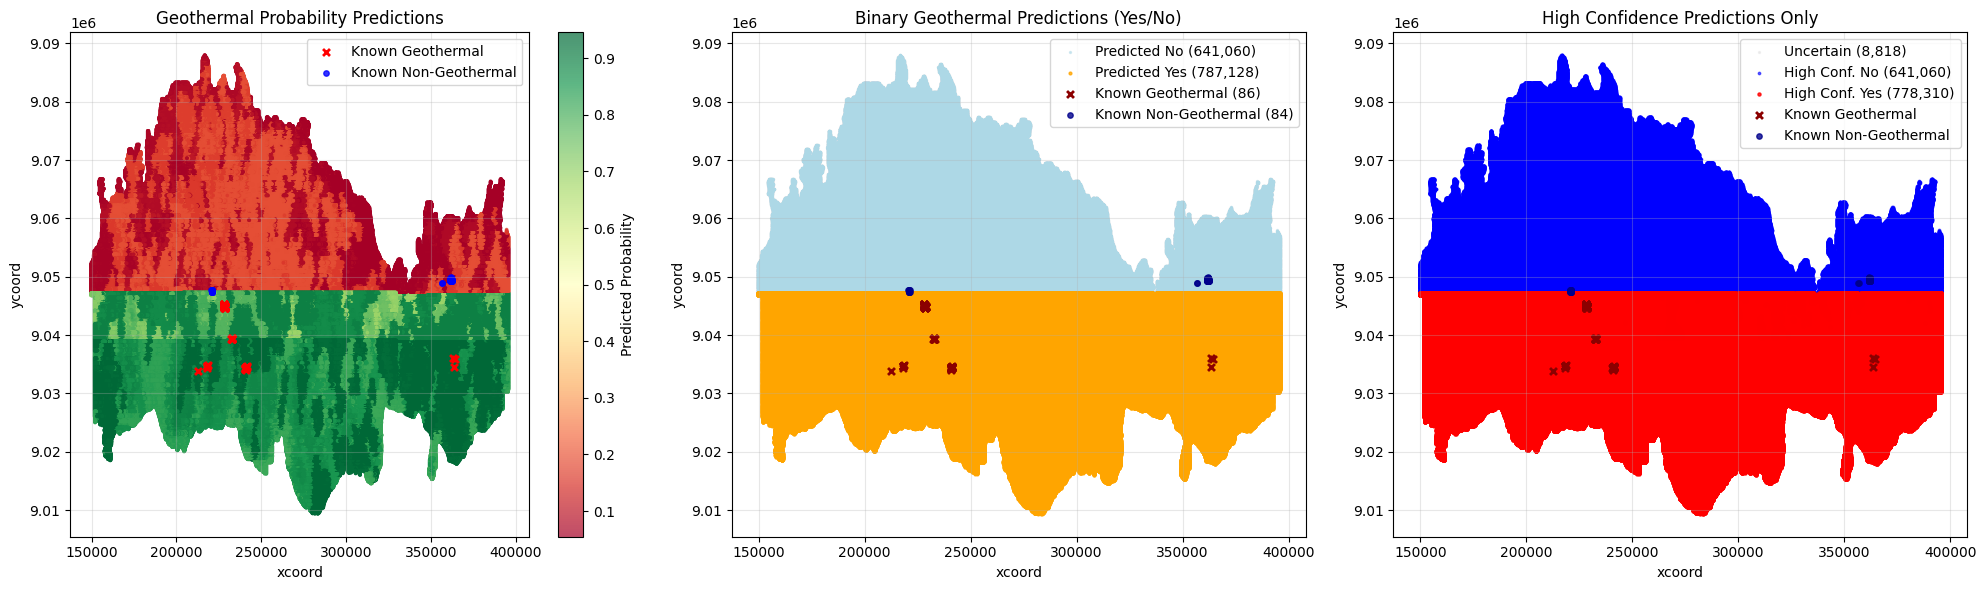


=== Prediction Summary ===
Total points predicted: 1,428,188
Predicted Geothermal (Yes): 787,128 (55.11%)
Predicted Non-Geothermal (No): 641,060 (44.89%)
High Confidence Yes (≥70%): 778,310 (54.50%)
High Confidence No (≤30%): 641,060 (44.89%)
Uncertain (30-70%): 8,818 (0.62%)


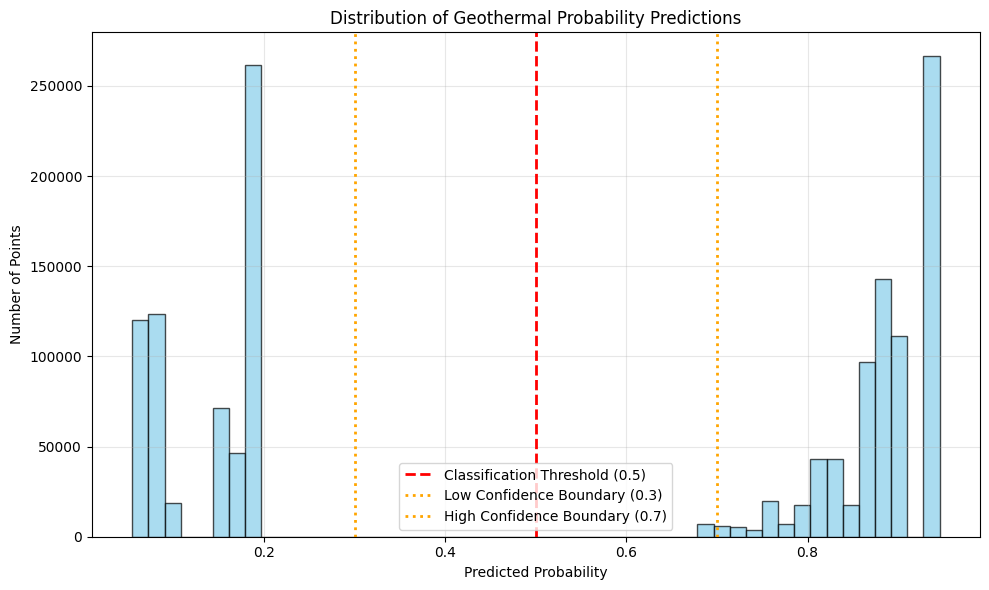

SyntaxError: 'return' outside function (1211689939.py, line 695)

In [82]:
def evaluate_on_known_locations(model, training_data, feature_cols):
    """
    Evaluate model by predicting on known locations without using their labels,
    then comparing predictions to the actual labels.
    
    Parameters:
    -----------
    model : trained model
        The trained XGBoost or other model
    training_data : DataFrame
        DataFrame with the labeled data
    feature_cols : list
        List of feature column names
    
    Returns:
    --------
    Dictionary of evaluation metrics
    """
    print("\n=== Evaluating Model on Known Locations ===")

    
    # Extract features and true labels from training data
    X_known = training_data[feature_cols].values
    y_true = training_data['Label'].values
    
    # Make predictions (pretending we don't know the labels)
    y_pred = model.predict(X_known)
    y_pred_proba = model.predict_proba(X_known)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    print("\n--- Performance Metrics ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix (All Known Locations)')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
    
    # Calculate area-specific accuracy
    if 'Area' in training_data.columns:
        print("\n--- Area-Specific Accuracy ---")
        area_metrics = {}
        unique_areas = training_data['Area'].dropna().unique()
        
        for area in unique_areas:
            area_mask = training_data['Area'] == area
            if sum(area_mask) > 0:  # Only proceed if we have data for this area
                area_X = training_data.loc[area_mask, feature_cols].values
                area_y = training_data.loc[area_mask, 'Label'].values
                area_pred = model.predict(area_X)
                
                area_accuracy = accuracy_score(area_y, area_pred)
                area_metrics[area] = {
                    'accuracy': area_accuracy,
                    'count': sum(area_mask),
                    'positive_rate': np.mean(area_y),
                    'predicted_positive_rate': np.mean(area_pred)
                }
                
                print(f"Area {area}: Accuracy = {area_accuracy:.4f}, Samples = {sum(area_mask)}")
        
        # Plot area-specific accuracy
        plt.figure(figsize=(12, 6))
        areas = list(area_metrics.keys())
        accuracies = [area_metrics[a]['accuracy'] for a in areas]
        counts = [area_metrics[a]['count'] for a in areas]
        
        # Sort by count for better visualization
        sorted_indices = np.argsort(counts)[::-1]
        sorted_areas = [areas[i] for i in sorted_indices]
        sorted_accs = [accuracies[i] for i in sorted_indices]
        sorted_counts = [counts[i] for i in sorted_indices]
        
        # Create bar chart with two y-axes
        fig, ax1 = plt.subplots(figsize=(14, 6))
        
        # Plot accuracy bars
        bars = ax1.bar(sorted_areas, sorted_accs, color='skyblue')
        ax1.set_ylim([0, 1.0])
        ax1.set_ylabel('Accuracy')
        ax1.set_xlabel('Area ID')
        ax1.axhline(y=accuracy, color='red', linestyle='--', label=f'Overall Accuracy: {accuracy:.3f}')
        
        # Add second y-axis for counts
        ax2 = ax1.twinx()
        ax2.plot(sorted_areas, sorted_counts, 'o-', color='green', label='Sample Count')
        ax2.set_ylabel('Number of Samples')
        
        # Add count labels above bars
        for i, count in enumerate(sorted_counts):
            ax2.text(i, count + max(sorted_counts)*0.03, str(count), ha='center')
        
        # Combine legends
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines + lines2, labels + labels2, loc='best')
        
        plt.title('Accuracy by Area')
        plt.tight_layout()
        plt.show()
    
    # Analyze predictions by probability thresholds
    print("\n--- Probability Threshold Analysis ---")
    thresholds = np.arange(0.0, 1.01, 0.1)
    threshold_metrics = []
    
    for threshold in thresholds:
        y_pred_t = (y_pred_proba >= threshold).astype(int)
        accuracy_t = accuracy_score(y_true, y_pred_t)
        precision_t = precision_score(y_true, y_pred_t, zero_division=0)
        recall_t = recall_score(y_true, y_pred_t, zero_division=0)
        f1_t = f1_score(y_true, y_pred_t, zero_division=0)
        
        threshold_metrics.append({
            'threshold': threshold,
            'accuracy': accuracy_t,
            'precision': precision_t,
            'recall': recall_t,
            'f1': f1_t
        })
    
    # Plot threshold analysis
    threshold_df = pd.DataFrame(threshold_metrics)
    plt.figure(figsize=(10, 6))
    plt.plot(threshold_df['threshold'], threshold_df['accuracy'], 'o-', label='Accuracy')
    plt.plot(threshold_df['threshold'], threshold_df['precision'], 'o-', label='Precision')
    plt.plot(threshold_df['threshold'], threshold_df['recall'], 'o-', label='Recall')
    plt.plot(threshold_df['threshold'], threshold_df['f1'], 'o-', label='F1 Score')
    plt.xlabel('Probability Threshold')
    plt.ylabel('Score')
    plt.title('Metric Performance by Probability Threshold')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Return results
    return {
        'overall_metrics': {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc
        },
        'area_metrics': area_metrics if 'area_metrics' in locals() else None,
        'threshold_analysis': threshold_metrics
    }
def perform_comprehensive_evaluation(model, training_data, prediction_data, feature_cols):
    """
    Perform a comprehensive evaluation of the model using multiple methods.
    
    Parameters:
    -----------
    model : trained model
        The trained model to evaluate
    training_data : DataFrame
        DataFrame with labeled data
    prediction_data : DataFrame
        DataFrame with unlabeled data for prediction
    feature_cols : list
        List of feature column names
    
    Returns:
    --------
    Dictionary with evaluation results
    """
    results = {}
    
    # 1. Basic evaluation on labeled data
    print("1. Evaluating on known locations...")
    basic_eval = evaluate_on_known_locations(model, training_data, feature_cols)
    results['basic_evaluation'] = basic_eval
    
    # 2. Leave-one-area-out cross-validation
    print("\n2. Performing leave-one-area-out validation...")
    loao_results = []
    
    if 'Area' in training_data.columns:
        unique_areas = training_data['Area'].dropna().unique()
        
        for left_out_area in unique_areas:
            # Split data
            train_mask = (training_data['Area'] != left_out_area) & training_data['Area'].notna()
            test_mask = training_data['Area'] == left_out_area
            
            # Skip if too few samples in either set
            if sum(train_mask) < 10 or sum(test_mask) < 5:
                print(f"Skipping area {left_out_area} - insufficient samples")
                continue
                
            # Create train/test datasets
            X_train_loao = training_data.loc[train_mask, feature_cols].values
            y_train_loao = training_data.loc[train_mask, 'Label'].values
            X_test_loao = training_data.loc[test_mask, feature_cols].values
            y_test_loao = training_data.loc[test_mask, 'Label'].values
            
            # Train model
            loao_model = xgb.XGBClassifier(
                objective='binary:logistic',
                random_state=42,
                scale_pos_weight=np.sum(y_train_loao == 0) / np.sum(y_train_loao == 1),
                **{k: v for k, v in model.get_params().items() if k in [
                    'max_depth', 'learning_rate', 'n_estimators', 
                    'subsample', 'colsample_bytree', 'gamma'
                ]}
            )
            loao_model.fit(X_train_loao, y_train_loao)
            
            # Evaluate
            y_pred_loao = loao_model.predict(X_test_loao)
            accuracy = accuracy_score(y_test_loao, y_pred_loao)
            
            print(f"Area {left_out_area}: Accuracy = {accuracy:.4f}, Test samples = {len(y_test_loao)}")
            
            loao_results.append({
                'area': left_out_area,
                'accuracy': accuracy,
                'test_samples': len(y_test_loao)
            })
    
        # Calculate average leave-one-area-out accuracy
        if loao_results:
            avg_loao_acc = np.mean([r['accuracy'] for r in loao_results])
            print(f"Average leave-one-area-out accuracy: {avg_loao_acc:.4f}")
            
            # Plot leave-one-area-out results
            loao_df = pd.DataFrame(loao_results)
            plt.figure(figsize=(12, 6))
            plt.bar(loao_df['area'], loao_df['accuracy'], color='skyblue')
            plt.axhline(y=avg_loao_acc, color='red', linestyle='--', 
                       label=f'Average: {avg_loao_acc:.3f}')
            plt.ylim([0, 1.0])
            plt.xlabel('Left Out Area')
            plt.ylabel('Accuracy')
            plt.title('Leave-One-Area-Out Validation Accuracy')
            plt.legend()
            plt.tight_layout()
            plt.show()
    
    results['leave_one_area_out'] = loao_results
    
    # Make predictions on full dataset
all_data = pd.concat([training_data, prediction_data], ignore_index=True)
all_X = all_data[feature_cols].values
all_proba = best_model.predict_proba(all_X)[:, 1]
all_binary = best_model.predict(all_X)  # Add binary predictions
all_data['Predicted_Probability'] = all_proba
all_data['Predicted_Binary'] = all_binary

# If we have spatial coordinates
coord_cols = []
for col in ['X', 'Y', 'x', 'y', 'xcoord', 'ycoord', 'lon', 'lat', 'longitude', 'latitude']:
    if col in all_data.columns:
        coord_cols.append(col)

if len(coord_cols) >= 2:
    # Use the first two coordinate columns found
    x_col, y_col = coord_cols[:2]
    
    # Create subplot with 3 maps side by side
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # 1. Probability heatmap
    scatter1 = axes[0].scatter(
        all_data[x_col],
        all_data[y_col],
        c=all_data['Predicted_Probability'],
        cmap='RdYlGn',
        s=3,
        alpha=0.7
    )
    
    # Mark known geothermal sites on probability map
    known_positive = training_data[training_data['Label'] == 1]
    known_negative = training_data[training_data['Label'] == 0]
    
    if len(known_positive) > 0:
        axes[0].scatter(
            known_positive[x_col],
            known_positive[y_col],
            c='red',
            marker='x',
            s=25,
            label='Known Geothermal',
            linewidths=2
        )
    
    if len(known_negative) > 0:
        axes[0].scatter(
            known_negative[x_col],
            known_negative[y_col],
            c='blue',
            marker='o',
            s=15,
            label='Known Non-Geothermal',
            alpha=0.8
        )
    
    plt.colorbar(scatter1, ax=axes[0], label='Predicted Probability')
    axes[0].set_xlabel(x_col)
    axes[0].set_ylabel(y_col)
    axes[0].set_title('Geothermal Probability Predictions')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 2. Binary predictions (Yes/No)
    # Separate predicted yes and no areas
    predicted_yes = all_data[all_data['Predicted_Binary'] == 1]
    predicted_no = all_data[all_data['Predicted_Binary'] == 0]
    
    # Plot predicted NO areas (background)
    axes[1].scatter(
        predicted_no[x_col],
        predicted_no[y_col],
        c='lightblue',
        s=2,
        alpha=0.5,
        label=f'Predicted No ({len(predicted_no):,})'
    )
    
    # Plot predicted YES areas (foreground)
    axes[1].scatter(
        predicted_yes[x_col],
        predicted_yes[y_col],
        c='orange',
        s=4,
        alpha=0.8,
        label=f'Predicted Yes ({len(predicted_yes):,})'
    )
    
    # Mark known sites
    if len(known_positive) > 0:
        axes[1].scatter(
            known_positive[x_col],
            known_positive[y_col],
            c='darkred',
            marker='x',
            s=25,
            label=f'Known Geothermal ({len(known_positive)})',
            linewidths=2
        )
    
    if len(known_negative) > 0:
        axes[1].scatter(
            known_negative[x_col],
            known_negative[y_col],
            c='darkblue',
            marker='o',
            s=15,
            label=f'Known Non-Geothermal ({len(known_negative)})',
            alpha=0.8
        )
    
    axes[1].set_xlabel(x_col)
    axes[1].set_ylabel(y_col)
    axes[1].set_title('Binary Geothermal Predictions (Yes/No)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # 3. High confidence predictions only
    # Show only high-confidence predictions (e.g., probability > 0.7 or < 0.3)
    high_conf_yes = all_data[all_data['Predicted_Probability'] >= 0.7]
    high_conf_no = all_data[all_data['Predicted_Probability'] <= 0.3]
    uncertain = all_data[(all_data['Predicted_Probability'] > 0.3) & 
                        (all_data['Predicted_Probability'] < 0.7)]
    
    # Plot uncertain areas (background)
    axes[2].scatter(
        uncertain[x_col],
        uncertain[y_col],
        c='lightgray',
        s=2,
        alpha=0.3,
        label=f'Uncertain ({len(uncertain):,})'
    )
    
    # Plot high confidence NO
    axes[2].scatter(
        high_conf_no[x_col],
        high_conf_no[y_col],
        c='blue',
        s=3,
        alpha=0.6,
        label=f'High Conf. No ({len(high_conf_no):,})'
    )
    
    # Plot high confidence YES
    axes[2].scatter(
        high_conf_yes[x_col],
        high_conf_yes[y_col],
        c='red',
        s=5,
        alpha=0.8,
        label=f'High Conf. Yes ({len(high_conf_yes):,})'
    )
    
    # Mark known sites
    if len(known_positive) > 0:
        axes[2].scatter(
            known_positive[x_col],
            known_positive[y_col],
            c='darkred',
            marker='x',
            s=25,
            label='Known Geothermal',
            linewidths=2
        )
    
    if len(known_negative) > 0:
        axes[2].scatter(
            known_negative[x_col],
            known_negative[y_col],
            c='darkblue',
            marker='o',
            s=15,
            label='Known Non-Geothermal',
            alpha=0.8
        )
    
    axes[2].set_xlabel(x_col)
    axes[2].set_ylabel(y_col)
    axes[2].set_title('High Confidence Predictions Only')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n=== Prediction Summary ===")
    print(f"Total points predicted: {len(all_data):,}")
    print(f"Predicted Geothermal (Yes): {len(predicted_yes):,} ({len(predicted_yes)/len(all_data)*100:.2f}%)")
    print(f"Predicted Non-Geothermal (No): {len(predicted_no):,} ({len(predicted_no)/len(all_data)*100:.2f}%)")
    print(f"High Confidence Yes (≥70%): {len(high_conf_yes):,} ({len(high_conf_yes)/len(all_data)*100:.2f}%)")
    print(f"High Confidence No (≤30%): {len(high_conf_no):,} ({len(high_conf_no)/len(all_data)*100:.2f}%)")
    print(f"Uncertain (30-70%): {len(uncertain):,} ({len(uncertain)/len(all_data)*100:.2f}%)")
    
    # Probability distribution histogram
    plt.figure(figsize=(10, 6))
    plt.hist(all_data['Predicted_Probability'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Classification Threshold (0.5)')
    plt.axvline(x=0.3, color='orange', linestyle=':', linewidth=2, label='Low Confidence Boundary (0.3)')
    plt.axvline(x=0.7, color='orange', linestyle=':', linewidth=2, label='High Confidence Boundary (0.7)')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Number of Points')
    plt.title('Distribution of Geothermal Probability Predictions')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Create separate detailed maps for Yes and No predictions
if len(coord_cols) >= 2:
    # Detailed map of predicted YES areas
    plt.figure(figsize=(15, 12))
    
    # Background: all points in light gray
    plt.scatter(
        all_data[x_col],
        all_data[y_col],
        c='lightgray',
        s=1,
        alpha=0.3
    )
    
    # Predicted YES areas with probability coloring
    predicted_yes_detailed = all_data[all_data['Predicted_Binary'] == 1]
    scatter_yes = plt.scatter(
        predicted_yes_detailed[x_col],
        predicted_yes_detailed[y_col],
        c=predicted_yes_detailed['Predicted_Probability'],
        cmap='Reds',
        s=8,
        alpha=0.8,
        vmin=0.5,  # Start colormap at 0.5 since these are all predicted positive
        vmax=1.0
    )
    
    # Mark known geothermal sites
    if len(known_positive) > 0:
        plt.scatter(
            known_positive[x_col],
            known_positive[y_col],
            c='black',
            marker='x',
            s=40,
            label=f'Known Geothermal Sites ({len(known_positive)})',
            linewidths=3
        )
    
    plt.colorbar(scatter_yes, label='Predicted Probability')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f'Predicted Geothermal Areas (Total: {len(predicted_yes_detailed):,} points)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Create area-based visualization if Area column exists
    if 'Area' in all_data.columns:
        print("\n=== Area-Based Prediction Summary ===")
        
        # Calculate statistics by area
        area_stats = []
        unique_areas = all_data['Area'].dropna().unique()
        
        for area in unique_areas:
            area_data = all_data[all_data['Area'] == area]
            if len(area_data) > 0:
                stats = {
                    'area': area,
                    'total_points': len(area_data),
                    'predicted_yes': sum(area_data['Predicted_Binary'] == 1),
                    'predicted_no': sum(area_data['Predicted_Binary'] == 0),
                    'avg_probability': area_data['Predicted_Probability'].mean(),
                    'max_probability': area_data['Predicted_Probability'].max(),
                    'min_probability': area_data['Predicted_Probability'].min()
                }
                stats['percent_yes'] = stats['predicted_yes'] / stats['total_points'] * 100
                area_stats.append(stats)
        
        # Convert to DataFrame and display
        area_df = pd.DataFrame(area_stats)
        area_df = area_df.sort_values('percent_yes', ascending=False)
        
        print("Top 10 areas by percentage of predicted geothermal points:")
        print(area_df[['area', 'total_points', 'predicted_yes', 'percent_yes', 'avg_probability']].head(10).to_string(index=False))
        
        # Plot area-based statistics
        plt.figure(figsize=(15, 8))
        
        # Bar plot of percentage yes by area
        plt.subplot(2, 2, 1)
        top_areas = area_df.head(15)  # Show top 15 areas
        plt.bar(range(len(top_areas)), top_areas['percent_yes'])
        plt.xlabel('Area Rank')
        plt.ylabel('% Predicted Geothermal')
        plt.title('Top Areas by % Predicted Geothermal')
        plt.xticks(range(len(top_areas)), top_areas['area'], rotation=45)
        
        # Scatter plot: total points vs predicted yes
        plt.subplot(2, 2, 2)
        plt.scatter(area_df['total_points'], area_df['predicted_yes'], alpha=0.6)
        plt.xlabel('Total Points in Area')
        plt.ylabel('Predicted Geothermal Points')
        plt.title('Predicted Geothermal vs Total Points by Area')
        
        # Histogram of average probabilities by area
        plt.subplot(2, 2, 3)
        plt.hist(area_df['avg_probability'], bins=20, alpha=0.7, color='green')
        plt.xlabel('Average Probability')
        plt.ylabel('Number of Areas')
        plt.title('Distribution of Average Probabilities by Area')
        
        # Box plot of probabilities by area type (if known)
        plt.subplot(2, 2, 4)
        if len(known_positive) > 0 and len(known_negative) > 0:
            positive_areas = known_positive['Area'].dropna().unique()
            negative_areas = known_negative['Area'].dropna().unique()
            
            pos_area_probs = []
            neg_area_probs = []
            
            for area in positive_areas:
                area_probs = all_data[all_data['Area'] == area]['Predicted_Probability']
                pos_area_probs.extend(area_probs.tolist())
            
            for area in negative_areas:
                area_probs = all_data[all_data['Area'] == area]['Predicted_Probability']
                neg_area_probs.extend(area_probs.tolist())
            
            plt.boxplot([pos_area_probs, neg_area_probs], 
                       labels=['Known Positive Areas', 'Known Negative Areas'])
            plt.ylabel('Predicted Probability')
            plt.title('Probability Distribution by Known Area Type')
        else:
            plt.text(0.5, 0.5, 'No area-based ground truth available', 
                    ha='center', va='center', transform=plt.gca().transAxes)
        
        plt.tight_layout()
        plt.show()
    
    # 4. Feature analysis by prediction correctness
    print("\n4. Analyzing feature values by prediction correctness...")
    
    # Make predictions on training data
    X_known = training_data[feature_cols].values
    y_true = training_data['Label'].values
    y_pred = model.predict(X_known)
    
    # Add prediction correctness to training data
    training_data['Prediction'] = y_pred
    training_data['Correct'] = training_data['Prediction'] == training_data['Label']
    training_data['PredictionType'] = 'Unknown'
    
    # Categorize predictions
    training_data.loc[(training_data['Label'] == 1) & (training_data['Prediction'] == 1), 'PredictionType'] = 'True Positive'
    training_data.loc[(training_data['Label'] == 0) & (training_data['Prediction'] == 0), 'PredictionType'] = 'True Negative'
    training_data.loc[(training_data['Label'] == 0) & (training_data['Prediction'] == 1), 'PredictionType'] = 'False Positive'
    training_data.loc[(training_data['Label'] == 1) & (training_data['Prediction'] == 0), 'PredictionType'] = 'False Negative'
    
    # Analyze feature distributions by prediction correctness
    fig, axes = plt.subplots(nrows=len(feature_cols), figsize=(12, 4*len(feature_cols)))
    
    for i, feature in enumerate(feature_cols):
        ax = axes[i]
        sns.boxplot(
            x='PredictionType', 
            y=feature, 
            data=training_data,
            order=['True Positive', 'True Negative', 'False Positive', 'False Negative'],
            ax=ax
        )
        ax.set_title(f'Distribution of {feature} by Prediction Type')
        ax.set_xlabel('')
        plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    # 5. Cross-feature relationships
    print("\n5. Analyzing relationships between key features...")
    
    # Identify the two most important features
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    top_features = feature_importance['Feature'].iloc[:2].tolist()
    
    if len(top_features) >= 2:
        plt.figure(figsize=(10, 8))
        
        # Plot feature relationships colored by actual label
        scatter = plt.scatter(
            training_data[top_features[0]],
            training_data[top_features[1]],
            c=training_data['Label'],
            cmap='coolwarm',
            alpha=0.6,
            s=30
        )
        
        # Add decision boundary
        x_min, x_max = training_data[top_features[0]].min(), training_data[top_features[0]].max()
        y_min, y_max = training_data[top_features[1]].min(), training_data[top_features[1]].max()
        
        xx, yy = np.meshgrid(
            np.linspace(x_min, x_max, 100),
            np.linspace(y_min, y_max, 100)
        )
        
        # Create a dummy dataset with just the top 2 features
        dummy_data = np.c_[xx.ravel(), yy.ravel()]
        # Fill in with median values for other features
        full_dummy = np.zeros((dummy_data.shape[0], len(feature_cols)))
        
        for i, feature in enumerate(feature_cols):
            if feature in top_features:
                idx = top_features.index(feature)
                full_dummy[:, i] = dummy_data[:, idx]
            else:
                full_dummy[:, i] = training_data[feature].median()
        
        # Get predictions for the grid
        Z = model.predict_proba(full_dummy)[:, 1]
        Z = Z.reshape(xx.shape)
        
        # Plot decision boundary
        plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
        
        plt.colorbar(scatter, label='Actual Label')
        plt.xlabel(top_features[0])
        plt.ylabel(top_features[1])
        plt.title(f'Relationship Between Top Features with Decision Boundary')
        plt.tight_layout()
        plt.show()
        return results

#coba vis di arcgis
#cari threshold

1. Evaluating on known locations...

=== Evaluating Model on Known Locations ===

--- Performance Metrics ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000


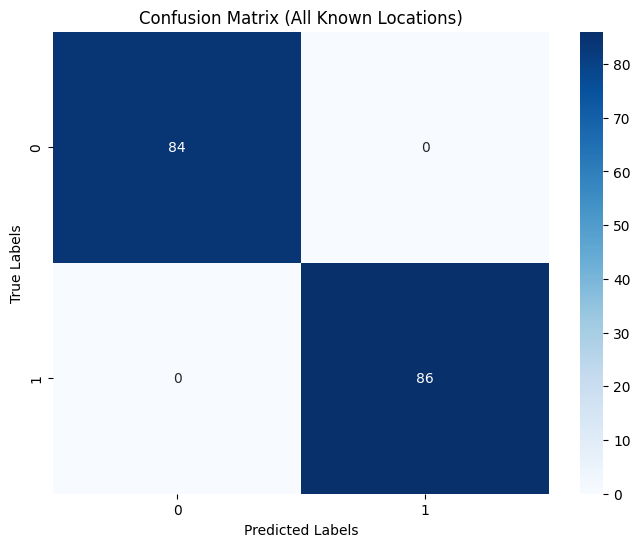


--- Area-Specific Accuracy ---
Area 1.0: Accuracy = 1.0000, Samples = 5
Area 2.0: Accuracy = 1.0000, Samples = 1
Area 3.0: Accuracy = 1.0000, Samples = 1
Area 4.0: Accuracy = 1.0000, Samples = 1
Area 10.0: Accuracy = 1.0000, Samples = 46
Area 15.0: Accuracy = 1.0000, Samples = 18
Area 11.0: Accuracy = 1.0000, Samples = 2
Area 12.0: Accuracy = 1.0000, Samples = 4
Area 14.0: Accuracy = 1.0000, Samples = 1
Area 21.0: Accuracy = 1.0000, Samples = 1
Area 23.0: Accuracy = 1.0000, Samples = 1
Area 24.0: Accuracy = 1.0000, Samples = 1
Area 33.0: Accuracy = 1.0000, Samples = 1
Area 40.0: Accuracy = 1.0000, Samples = 1
Area 36.0: Accuracy = 1.0000, Samples = 1
Area 50.0: Accuracy = 1.0000, Samples = 1
Area 300.0: Accuracy = 1.0000, Samples = 59
Area 200.0: Accuracy = 1.0000, Samples = 23
Area 100.0: Accuracy = 1.0000, Samples = 2


<Figure size 1200x600 with 0 Axes>

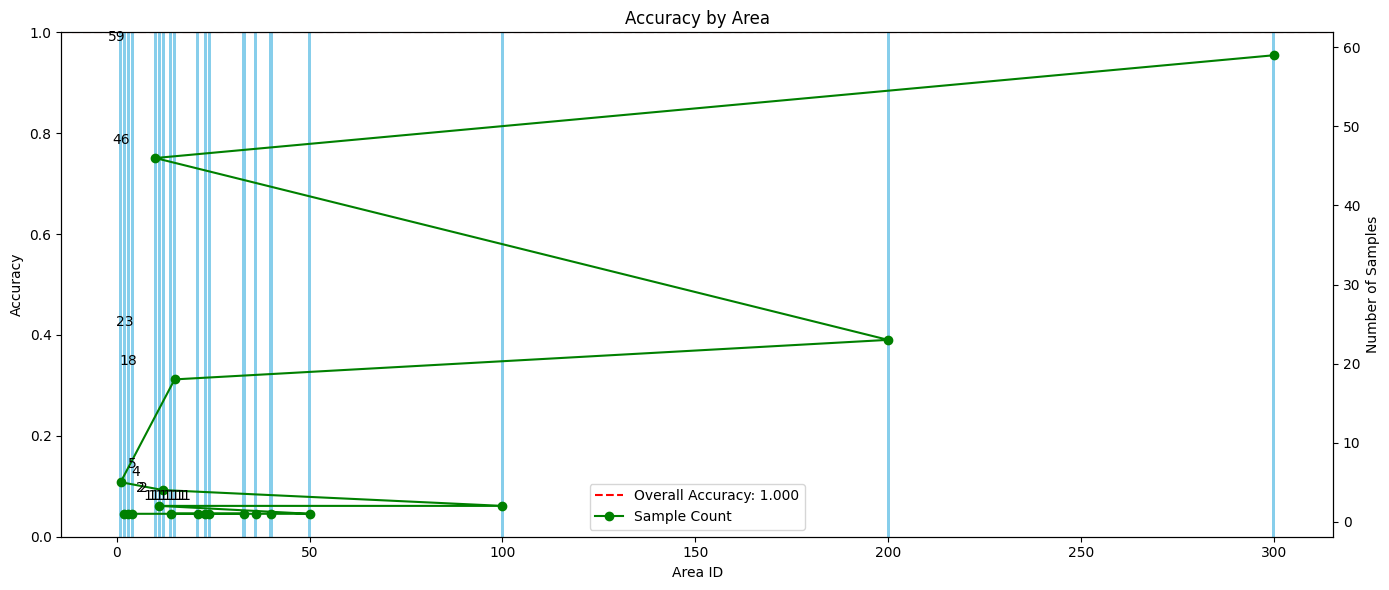


--- Probability Threshold Analysis ---


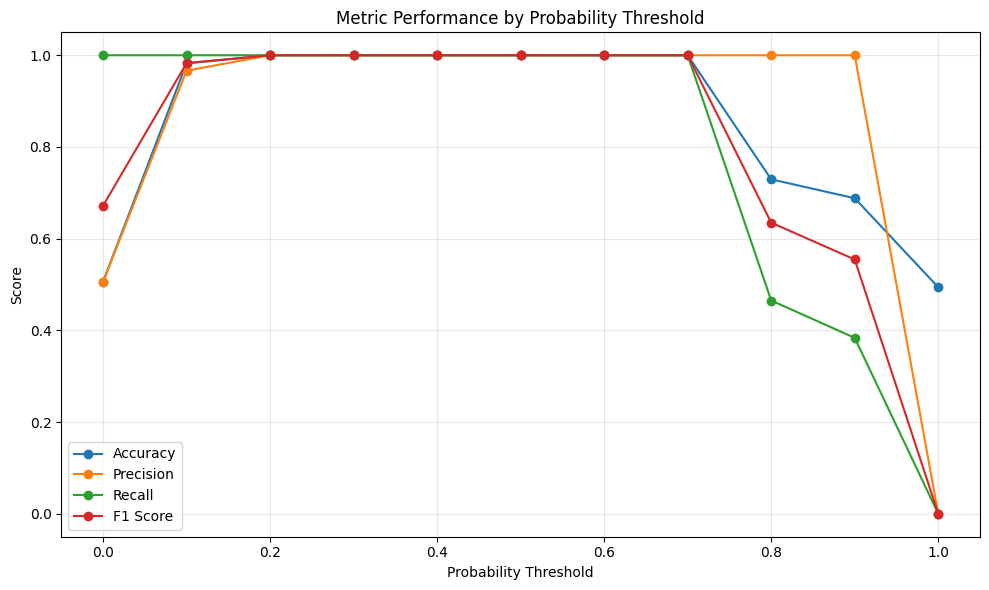


2. Performing leave-one-area-out validation...
Area 1.0: Accuracy = 1.0000, Test samples = 5
Skipping area 2.0 - insufficient samples
Skipping area 3.0 - insufficient samples
Skipping area 4.0 - insufficient samples
Area 10.0: Accuracy = 1.0000, Test samples = 46
Area 15.0: Accuracy = 1.0000, Test samples = 18
Skipping area 11.0 - insufficient samples
Skipping area 12.0 - insufficient samples
Skipping area 14.0 - insufficient samples
Skipping area 21.0 - insufficient samples
Skipping area 23.0 - insufficient samples
Skipping area 24.0 - insufficient samples
Skipping area 33.0 - insufficient samples
Skipping area 40.0 - insufficient samples
Skipping area 36.0 - insufficient samples
Skipping area 50.0 - insufficient samples
Area 300.0: Accuracy = 1.0000, Test samples = 59
Area 200.0: Accuracy = 0.0000, Test samples = 23
Skipping area 100.0 - insufficient samples
Average leave-one-area-out accuracy: 0.8000


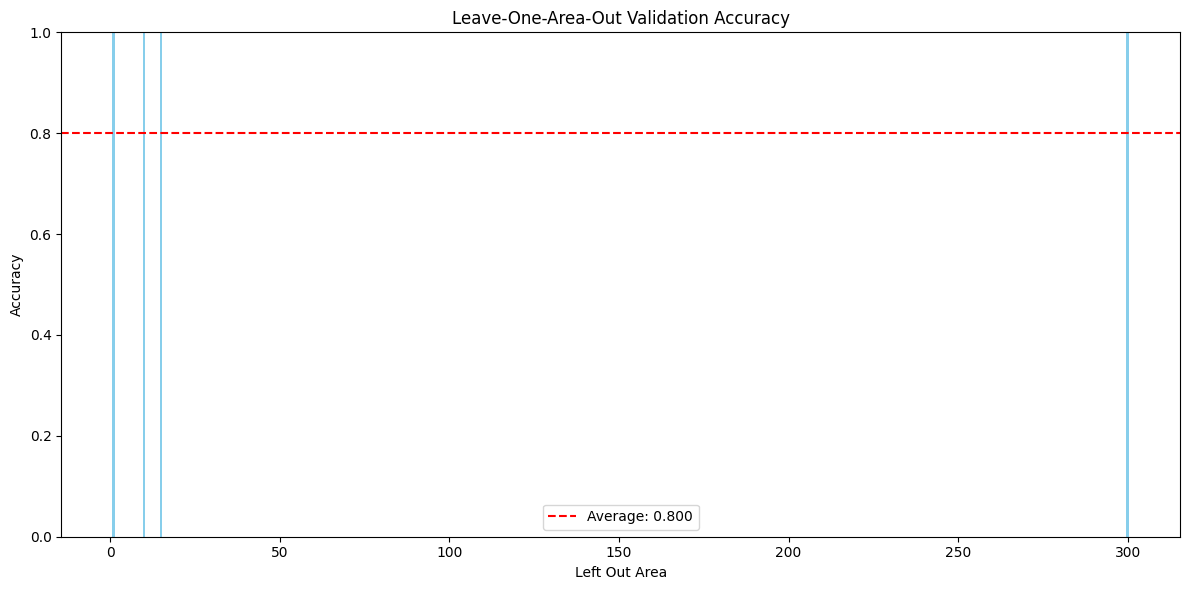

In [80]:
comprehensive_results = perform_comprehensive_evaluation(
    best_model, 
    training_data, 
    prediction_data, 
    feature_cols
)

In [36]:
#Load hasil prediction dari RapidMiner
df2 = pd.read_csv('C:/Tugas/Sem 8/TA/RESULT_XGB_3.csv')
stats = df2.describe()
print(stats)

label_counts = df2['prediction(Label)'].value_counts()
print("\nCounts of values in Label column:")
print(label_counts)

# Calculate percentages
label_percentages = df2['prediction(Label)'].value_counts(normalize=True) * 100
print("\nPercentages:")
for label, percentage in label_percentages.items():
    print(f"Label {label}: {percentage:.2f}%")

         LST_Celciu             Z          NDVI          NDWI           VHI  \
count  1.358465e+06  1.358465e+06  1.358465e+06  1.358465e+06  1.358465e+06   
mean   3.005953e+01  5.223473e+02  3.343151e-01  1.883504e-01  5.862986e+01   
std    5.847788e+00  3.712117e+02  1.313488e-01  8.602190e-02  7.635076e+00   
min    0.000000e+00 -8.000000e+00 -2.406666e-01 -2.885412e-01  1.903827e+01   
25%    2.600000e+01  2.320000e+02  2.392881e-01  1.319480e-01  5.345405e+01   
50%    2.968612e+01  4.570000e+02  3.598928e-01  1.959821e-01  5.953313e+01   
75%    3.332222e+01  7.470000e+02  4.434680e-01  2.571661e-01  6.374503e+01   
max    9.960001e+01  2.353000e+03  6.306279e-01  5.009352e-01  8.409676e+01   

          Linedense     LapseRate        Label  confidence(0.0)  \
count  1.358465e+06  1.358465e+06  7955.000000     1.358465e+06   
mean   6.672891e-01  1.896626e-01     0.562665     3.168285e-01   
std    1.704587e-01  3.285739e+00     0.496089     2.409907e-01   
min    8.784500e-03 

In [ ]:
#Load hasil prediction dari RapidMiner
df2 = pd.read_csv('C:/Tugas/Sem 8/TA/geothermal_predictions_complete.csv')
stats = df2.describe()
print(stats)

label_counts = df2['Label'].value_counts()
print("\nCounts of values in Label column:")
print(label_counts)

# Calculate percentages
label_percentages = df2['Label' \
'' \
''].value_counts(normalize=True) * 100
print("\nPercentages:")
for label, percentage in label_percentages.items():
    print(f"Label {label}: {percentage:.2f}%")

          LapseRate        xcoord        ycoord    LST_Celciu          NDVI  \
count  1.256279e+06  1.256279e+06  1.256279e+06  1.256279e+06  1.256279e+06   
mean   2.016813e-01  2.598089e+05  9.046707e+06  2.989211e+01  3.675948e-01   
std    2.634551e+00  6.542684e+04  1.607459e+04  5.286587e+00  1.210078e-01   
min   -7.695694e+00  1.495937e+05  9.009380e+06  1.348055e+01 -2.417189e-02   
25%   -1.333031e+00  2.062037e+05  9.033680e+06  2.607501e+01  3.128579e-01   
50%    1.905158e-01  2.518337e+05  9.045830e+06  2.970000e+01  4.085258e-01   
75%    1.609516e+00  3.047537e+05  9.058430e+06  3.320001e+01  4.525468e-01   
max    8.012818e+00  3.958337e+05  9.088040e+06  4.810001e+01  7.632228e-01   

               NDWI           SMI           VHI         Label             Z  \
count  1.256279e+06  1.256279e+06  1.256279e+06  1.256279e+06  1.256279e+06   
mean   1.994168e-01  2.506197e-01  3.675948e-01  3.402206e-01  5.104735e+02   
std    6.226651e-02  3.386031e-02  1.210078e-01  4.